## Install and import

In [ ]:
!pip install sentencepiece
!pip install tf_sentencepiece
!pip install fastai==1.0.52

     |████████████████████████████████| 1.2 MB 4.3 MB/s 
     |████████████████████████████████| 2.1 MB 4.3 MB/s 
     |████████████████████████████████| 219 kB 4.4 MB/s 
     |████████████████████████████████| 78 kB 2.7 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=eeb50807f7f592d11199b7cea9991635429d31ceb308dd86acdea931756a84a6
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai import *
from fastai.text import *
import re
import sentencepiece as spm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
kfold16 = path/'Thesis Data'/'kfold'/'baad16'
kfold6 = path/'Thesis Data'/'kfold'/'baad6'

## Data View

### BAAD6

In [ ]:
baad6_train = pd.read_csv(aa2/'ulm_train.csv')
baad6_test = pd.read_csv(aa2/'ulm_test.csv')
len(baad6_train), len(baad6_test)

(1800, 300)

In [ ]:
baad6 = pd.concat([baad6_train,baad6_test])
len(baad6)

2100

In [ ]:
baad6.label.nunique()

6

In [ ]:
baad6.label.value_counts()

mk    350
rn    350
hm    350
rg    350
ij    350
fe    350
Name: label, dtype: int64

### BAAD16

In [ ]:
baad16_train = pd.read_csv(aa/'OurDataset_train.csv')
baad16_test = pd.read_csv(aa/'OurDataset_test.csv')
len(baad16_train), len(baad16_test), len(baad16_test)*100/(len(baad16_train)+len(baad16_test)) ## each author is divided into splits

(14374, 3592, 19.993320716909718)

In [ ]:
df_counts = pd.DataFrame(baad16_train.label.value_counts())
df_counts['test'] = pd.DataFrame(baad16_test.label.value_counts()).label
df_counts['percent'] = (df_counts['test']*100/(df_counts['label']+df_counts['test'])).round(3)
df_counts

,label,test,percent
humayun_ahmed,3612,906,20.053
shunil_gongopaddhay,1570,393,20.020
shomresh,1126,282,20.028
shorotchandra,1051,261,19.893
robindronath,1007,252,20.016
MZI,880,220,20.000
shirshendu,838,210,20.038
toslima_nasrin,745,186,19.979
shordindu,711,177,19.932
shottojit_roy,680,169,19.906


In [ ]:
baad16 = pd.read_csv(aa/'full.csv')
len(baad16)

17966

In [ ]:
baad16.label.nunique()

16

In [ ]:
baad16.label.value_counts()

humayun_ahmed          4518
shunil_gongopaddhay    1963
shomresh               1408
shorotchandra          1312
robindronath           1259
MZI                    1100
shirshendu             1048
toslima_nasrin          931
shordindu               888
shottojit_roy           849
tarashonkor             775
bongkim                 562
nihar_ronjon_gupta      476
manik_bandhopaddhay     469
nazrul                  223
zahir_rayhan            185
Name: label, dtype: int64

## Load sentence piece

In [ ]:
vocab_size = 30000
model_prefix = news/'sp'

In [ ]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [ ]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

In [ ]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])
sp_vocab = Vocab(itos)
len(itos)

30000

## Utils

In [ ]:
def testing(df, classifier):
  # df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = classifier.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  acc = count/tst
  print("Accuracy: ")
  print(acc)
  print(err)
  return final_preds, targets, err, acc

In [ ]:
bs = 32
bptt = 70
moms = (0.8,0.7)

## BAAD16 K-fold

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
accuracies = [0.9927657206455203, 0.9924853882549401, 0.9871973281380462]
f1_scores = [0.9927830579714404, 0.9924854047529802, 0.9869630088413186]
predictions = []
targets = []
errors = []

skf = StratifiedKFold(n_splits=5)
splits = skf.split(baad16[['text']], baad16[['label']])

In [ ]:
def train_one_split(train_index, test_index):
  X_train, X_test = baad16[['text']].loc[train_index], baad16[['text']].loc[test_index]
  y_train, y_test = baad16[['label']].loc[train_index], baad16[['label']].loc[test_index]
  train_df = pd.concat([X_train,y_train], axis=1)
  test_df = pd.concat([X_test,y_test], axis=1)

  train_df, valid_df = train_test_split(train_df, test_size=0.25, stratify=train_df['label'], random_state=42)
  ln_train = len(train_df)
  ln_valid = len(valid_df)
  ln_test = len(test_df)
  ln_total = ln_train + ln_valid + ln_test
  print("TRAIN len:", ln_train, "VALID len:", ln_valid, "TEST len:", ln_test, 
        "VALID percent:", np.round(ln_valid*100/ln_total,3),
        "TEST percent:", np.round(ln_test*100/ln_total,3))
  
  ## SET UP DATA
  data_clas = TextClasDataBunch.from_df(path=kfold16, train_df=train_df,valid_df=valid_df,
                                        tokenizer=mycust_tok,vocab=sp_vocab,bs=bs,text_cols='text',label_cols='label')
  learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
  learn_cls.load_encoder(aa/'models'/'AA_subword_lm_enc') ## model pre-trained on news dataset, then finetuned on AA dataset
  
  ## TRAIN CLASSIFIER 10 EPOCHS
  learn_cls.freeze()
  learn_cls.lr_find()
  learn_cls.recorder.plot(suggestion=True)
  min_grad_lr = learn_cls.recorder.min_grad_lr
  learn_cls.fit_one_cycle(2, min_grad_lr, moms=moms) # learn_cls.save('')

  learn_cls.freeze_to(-2)
  learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

  learn_cls.freeze_to(-3)
  learn_cls.fit_one_cycle(2 , slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

  learn_cls.unfreeze()
  learn_cls.lr_find()
  try:
    learn_cls.recorder.plot(suggestion=True)
    min_grad_lr = learn_cls.recorder.min_grad_lr
  except:
    pass
  learn_cls.fit_one_cycle(4, slice(min_grad_lr/(2.6**4),min_grad_lr), moms=moms)

  ## TESTING
  preds, targs, err, acc = testing(test_df, learn_cls)
  f1 = f1_score(targs, preds, average='weighted')

  ## SAVING RESULTS
  accuracies.append(acc)
  f1_scores.append(f1)
  predictions.append(preds)
  targets.append(targs)
  errors.append(err)

  print(acc, f1)

TRAIN len: 10779 VALID len: 3593 TEST len: 3594 VALID percent: 19.999 TEST percent: 20.004


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.153322,0.049113,0.987197,13:40
1,0.063275,0.031401,0.992764,13:19


epoch,train_loss,valid_loss,accuracy,time
0,0.142419,0.077656,0.981074,15:46
1,0.038318,0.027641,0.993599,15:54


epoch,train_loss,valid_loss,accuracy,time
0,0.168995,0.420064,0.936265,22:50
1,0.028783,0.018684,0.994990,23:08


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.015961,0.019005,0.994990,28:44
1,0.020388,0.019555,0.994990,29:22
2,0.023615,0.018873,0.994990,28:53
3,0.015104,0.019833,0.994434,29:14


3594
Accuracy: 
0.9927657206455203
[('manik_bandhopaddhay', 'tarashonkor'), ('manik_bandhopaddhay', 'tarashonkor'), ('shordindu', 'humayun_ahmed'), ('nazrul', 'shomresh'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'nihar_ronjon_gupta'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'shunil_gongopaddhay'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'zahir_rayhan'), ('humayun_ahmed', 'shomresh'), ('humayun_ahmed', 'MZI'), ('shirshendu', 'shomresh'), ('shunil_gongopaddhay', 'tarashonkor'), ('toslima_nasrin', 'humayun_ahmed'), ('tarashonkor', 'manik_bandhopaddhay')]
0.9927657206455203 0.9927830579714404


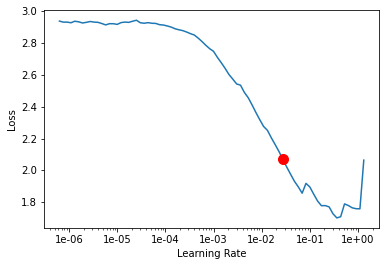

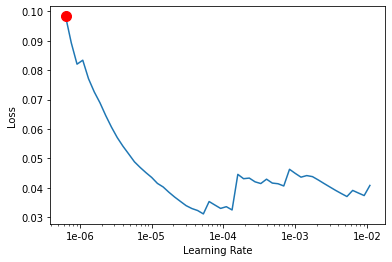

In [ ]:
## 1
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.137521,0.043220,0.986644,13:50
1,0.071252,0.026330,0.993600,13:57


epoch,train_loss,valid_loss,accuracy,time
0,0.143815,0.027827,0.992209,15:51
1,0.028539,0.020539,0.995270,15:54


epoch,train_loss,valid_loss,accuracy,time
0,0.128542,0.313182,0.945465,23:37
1,0.030615,0.013808,0.995826,23:06


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.017549,0.012641,0.996383,30:15
1,0.019997,0.011295,0.997218,28:58
2,0.018015,0.011810,0.996661,29:31
3,0.017960,0.013544,0.995826,29:37


3593
Accuracy: 
0.9924853882549401
[('shottojit_roy', 'shordindu'), ('robindronath', 'nazrul'), ('robindronath', 'shunil_gongopaddhay'), ('robindronath', 'shottojit_roy'), ('robindronath', 'shordindu'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'tarashonkor'), ('humayun_ahmed', 'shunil_gongopaddhay'), ('nihar_ronjon_gupta', 'tarashonkor'), ('nihar_ronjon_gupta', 'shomresh'), ('nihar_ronjon_gupta', 'shomresh'), ('shirshendu', 'shunil_gongopaddhay'), ('shirshendu', 'shunil_gongopaddhay'), ('shirshendu', 'manik_bandhopaddhay'), ('shirshendu', 'MZI'), ('shirshendu', 'MZI'), ('shomresh', 'shunil_gongopaddhay'), ('shomresh', 'humayun_ahmed'), ('toslima_nasrin', 'humayun_ahmed'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'nihar_ronjon_gupta')]
0.9924853882549401 0.99248540

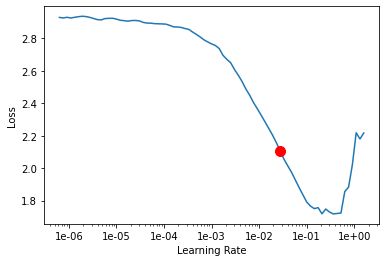

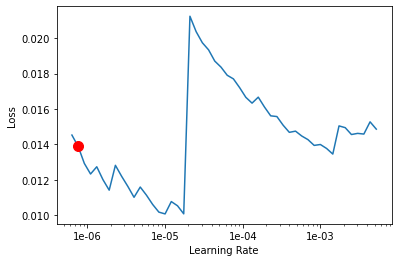

In [ ]:
## 2
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.146044,0.034622,0.991653,19:04
1,0.050261,0.028711,0.993044,19:27


epoch,train_loss,valid_loss,accuracy,time
0,0.086670,0.039789,0.991374,22:11
1,0.040963,0.024703,0.994435,21:47


epoch,train_loss,valid_loss,accuracy,time
0,0.099573,0.026820,0.991374,31:44
1,0.029504,0.029120,0.992766,31:48


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


epoch,train_loss,valid_loss,accuracy,time
0,0.014109,0.027704,0.993044,39:45


epoch,train_loss,valid_loss,accuracy,time
0,0.014109,0.027704,0.993044,39:45
1,0.028390,0.027052,0.993600,40:03
2,0.014898,0.028602,0.992766,39:14
3,0.038602,0.022882,0.993879,38:51


3593
Accuracy: 
0.9871973281380462
[('manik_bandhopaddhay', 'shirshendu'), ('manik_bandhopaddhay', 'shirshendu'), ('manik_bandhopaddhay', 'shirshendu'), ('manik_bandhopaddhay', 'tarashonkor'), ('manik_bandhopaddhay', 'shirshendu'), ('manik_bandhopaddhay', 'zahir_rayhan'), ('MZI', 'humayun_ahmed'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'shorotchandra'), ('shordindu', 'shorotchandra'), ('shordindu', 'shorotchandra'), ('shordindu', 'shorotchandra'), ('shordindu', 'bongkim'), ('shordindu', 'bongkim'), ('shordindu', 'bongkim'), ('shordindu', 'bongkim'), ('shordindu', 'bongkim'), ('shordindu', 'shorotchandra'), ('shordi

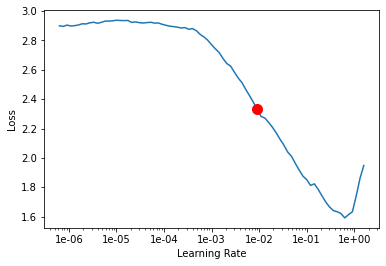

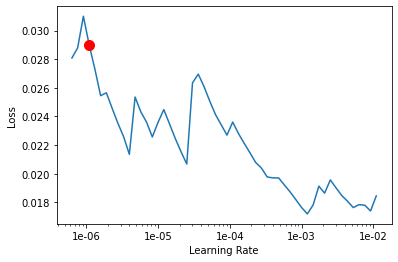

In [ ]:
## 3
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

In [ ]:
## 4
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

TRAIN len: 10779 VALID len: 3594 TEST len: 3593 VALID percent: 20.004 TEST percent: 19.999


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.222876,0.087379,0.975237,13:13
1,0.060942,0.037052,0.992209,13:06


epoch,train_loss,valid_loss,accuracy,time
0,0.149532,0.045981,0.988592,15:05
1,0.053814,0.033943,0.994435,15:11


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
## 5
train_index, test_index = next(splits)
train_one_split(train_index, test_index)

In [ ]:
accuracies, f1_scores, errors

In [ ]:
# cm=confusion_matrix(targ, pred)
# df_cm = pd.DataFrame(cm, range(16),range(16))
# plt.figure(figsize = (10,7))
# sn.set(font_scale=1.4)#for label size
# sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap="YlGnBu")# font size

# plt.savefig('news_subword_baad16_cm.eps')
# files.download('news_subword_baad16_cm.eps')